In [40]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split

nlp = spacy.load("en_core_web_sm")
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.remove('up')
stopword_list.remove('down')

In [8]:
df = pd.read_csv('all-data.csv', names = ['labels','messages'],encoding='ISO-8859-1')

In [9]:
df.head()

,labels,messages
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


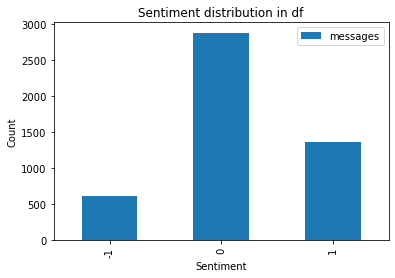

In [51]:
df.groupby(['labels']).count().plot.bar()
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Sentiment distribution in df")
plt.show()

In [14]:
### remove stopwords

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [31]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [49]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("Returning books is something I remain thinking about") #odd sentence, I know

'return book be something I remain think about'

In [33]:
def normalize_text(text):
    exp = expand_contractions(text)
    low = exp.lower()
    lemm = lemmatize_text(low)
    no_sw = remove_stopwords(lemm)
    return simple_preprocess(no_sw)

In [36]:
#### text preprocess:

df['messages'] = [normalize_text(row) for row in df['messages']]

In [42]:
df.iloc[0]['messages'][:3]

['accord', 'gran', 'company']

In [43]:
### map sentiment to int:

def map_sentiment(sentiment):
    if sentiment == 'negative':
        return -1
    elif sentiment == 'neutral':
        return 0
    else:
        return 1

In [44]:
df['labels'] = [map_sentiment(row) for row in df['labels']]

In [47]:
df['labels'].head(3)

0    0
1    0
2   -1
Name: labels, dtype: int64

Number of rows per sentiment:
 0    2879
 1    1363
-1     604
Name: labels, dtype: int64


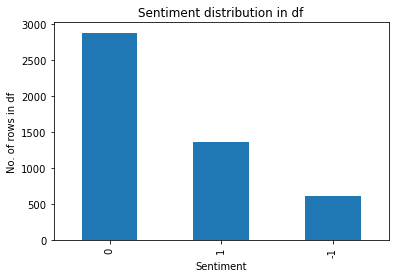

In [52]:
print("Number of rows per sentiment:")
print(df['labels'].value_counts())

plt.figure()
pd.value_counts(df['labels']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [53]:
# Train-Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True, ):
    X_train, X_test, Y_train, Y_test = train_test_split(df['messages'], 
                                                        df['labels'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
 0    2000
 1     956
-1     436
Name: labels, dtype: int64
Value counts for Test sentiments
 0    879
 1    407
-1    168
Name: labels, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                           messages
0   2988  [market, share, percent, accord, ac, nielsen, ...
1   3236                   [ecb, mainly, target, inflation]
2   2061  [scania, morgan, stanley, lift, share, target,...
3   3002  [kirsi, rantanen, previously, development, dir...
4   1417  [russian, government, contribute, necessary, f...
